# Exercise 3 - Grasp classification using EMG signals to control a robotic hand prosthesis

In this exercise you will process EMG signals in order to decode motor intentions of the user. 

We recorded an EMG dataset that consists of a user performing different single finger and multi-finger grasps. The subject was asked to follow a virtual hand and perform the same movements to synchronize EMG and finger movements.

In the dataset available in the folder data_csv there are two csv files (EMG signals and finger positions). Finger values are 0 when a finger is opened, 1 at rest position and 2 when it is closed. We recorded 6 EMG channels at 2kHz and finger states at 60Hz.

Finger states are saved as a matrix where rows correspond to time and columns correspond to one joint (Thump opposition, Thumb, Index, Middle, Ring, Pinky). See the following image:

<img src="figures\figures\hand_model.png" alt="Drawing" style="width: 400px;"/>

The sequence of movements is made of the following movements held for 5 seconds with a rest position of 3 seconds in between everytime: pinky flexion, ulnar flexion, middle flexion, index flexion, thumb opposition, ulnar grasp, tri-digital grasp, pincer grasp, thumb up, lateral (key) grasp, power grasp, open (note that there is no rest position between thumb up and lateral grasp).

You can see forearm muscle anatomy and function following these two links:

- https://teachmeanatomy.info/upper-limb/muscles/posterior-forearm/
- https://teachmeanatomy.info/upper-limb/muscles/anterior-forearm/

This jupyter notebook will:
- load the .csv files (EMG + Targets)
- Plot the raw data for visual inspection
- Synchronize EMG and Targets since they are recorded as two separate streams of data (2000kHz for the EMG and 60Hz for the Targets)

The aim of this exercise is to design and explore different machine learning models capable of decoding user intentions to control a robotic prosthetic hand. You will have to assess performance on unseen data to quantify the accuracy expected in a real experiment.

For the model to work in a real world scenario, the model should be fast enough to be able to decode motor intention with a small amount of data (200ms of signal is a standard value). We will use a sliding window to "cut" the data in samples that will be used to make the classification. The windows are overlapped to increase the amount of samples to train the model (see https://doi.org/10.3390/s19204596 chapter 3.2). 

However, the signal itself is usually too complex to train a machine learning model. A standard approach to train a classifier is to extract meaninful and discriminative features from the signal and use it to train the model (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307).

You can choose the model type and classification type (see https://scikit-learn.org/stable/modules/multiclass.html). You are free to choose the classification type (multi-class, multi-output,...) depending on how you will prepare the targets.

Therefore, you will have to:
- Divide the whole dataset into the three following sets: Training, Validation and Testing set.
- Extract sliding windows of 200ms from the EMG signal with an overlap of 50ms and prepare the Targets as the grasp type at the end of the time window.
- Adapt targets for grasp classification
- Extract meaningful information from raw EMG data (Feature extraction)
- Create and compare different machine learning models to decode user intention
- Evaluate performance of the final model you chose
- Plot predictions made by your model

The following figure summurize the different steps required to obtain an real-time EMG decoder:
!['title'](figures/figures\figure_1.png)


In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter
from scipy.signal import sosfiltfilt
import time
import seaborn as sns
sns.set()

from align import align

### Some parameters

In [2]:
window_length = 0.2 #200 ms
sliding_step = 0.05 #50 ms
sampling_frequency_EMG = 2000 #Hz   
sampling_frequency_Targets = 60 #Hz   

### First Load the files

Run the commented code to download the data if you haven't

In [3]:
# !pip install gdown
# import gdown
# url = "https://drive.google.com/uc?id=1gYq_L50vXhEHIURerpW-IluyzgPrOWFZ"
# output = "EMG.csv"
# gdown.download(url, output, quiet = False)
# url = "https://drive.google.com/uc?id=1WoJA80wRaf2_LJv_BtazGQ6V11F0n8iR"
# output = "action_list.npy"
# gdown.download(url, output, quiet = False)
# url = "https://drive.google.com/uc?id=1TUy0V40Rvj9mR39T9JFtgIEP6Fut7luq"
# output = "Kinematics.csv"
# gdown.download(url, output, quiet = False)

In [4]:
EMG_file_name='./EMG.csv'
target_file_name='./Kinematics.csv'

EMG_df = pd.read_csv(EMG_file_name,index_col='index')
Targets_df = pd.read_csv(target_file_name,index_col='index')
Targets_df = (Targets_df*2).astype(int) #convert into 0, 1, and 2 for label

## Data inspection

In [5]:
EMG_df.head()

,Labjack_channel1,Labjack_channel2,Labjack_channel3,Labjack_channel4,Labjack_channel5,Labjack_channel6
index,,,,,,
0.0000,0.035438,0.025026,0.016822,0.021555,0.019977,0.006725
0.0005,0.035123,0.026288,0.016506,0.019662,0.021555,0.005463
0.0010,0.035438,0.026603,0.018084,0.019346,0.021870,0.005463
0.0015,0.033230,0.025972,0.018715,0.020924,0.020293,0.004832
0.0020,0.033545,0.029443,0.018084,0.023133,0.020608,0.005778


In [6]:
Targets_df.head()

,Right_Hand_channel1,Right_Hand_channel2,Right_Hand_channel3,Right_Hand_channel4,Right_Hand_channel5,Right_Hand_channel6
index,,,,,,
5.39584,1,1,1,1,1,1
5.41117,1,1,1,1,1,1
5.42762,1,1,1,1,1,1
5.44352,1,1,1,1,1,1
5.45937,1,1,1,1,1,1


In [7]:
# Get number of channels and number of samples
n_channels = EMG_df.shape[1]
n_samples = EMG_df.shape[0]

# Convert into numpy array for easier manipulation
EMG = np.array(EMG_df.values)

Targets = np.array(Targets_df.values)


In [8]:
# Preprocess the data with a bandpass filter
Wn = (5, 500) 
sos = butter(N=8, Wn=Wn, fs=sampling_frequency_EMG, btype="bandpass", output="sos") 
EMG = sosfiltfilt(sos, EMG.T).T 

### Plot data

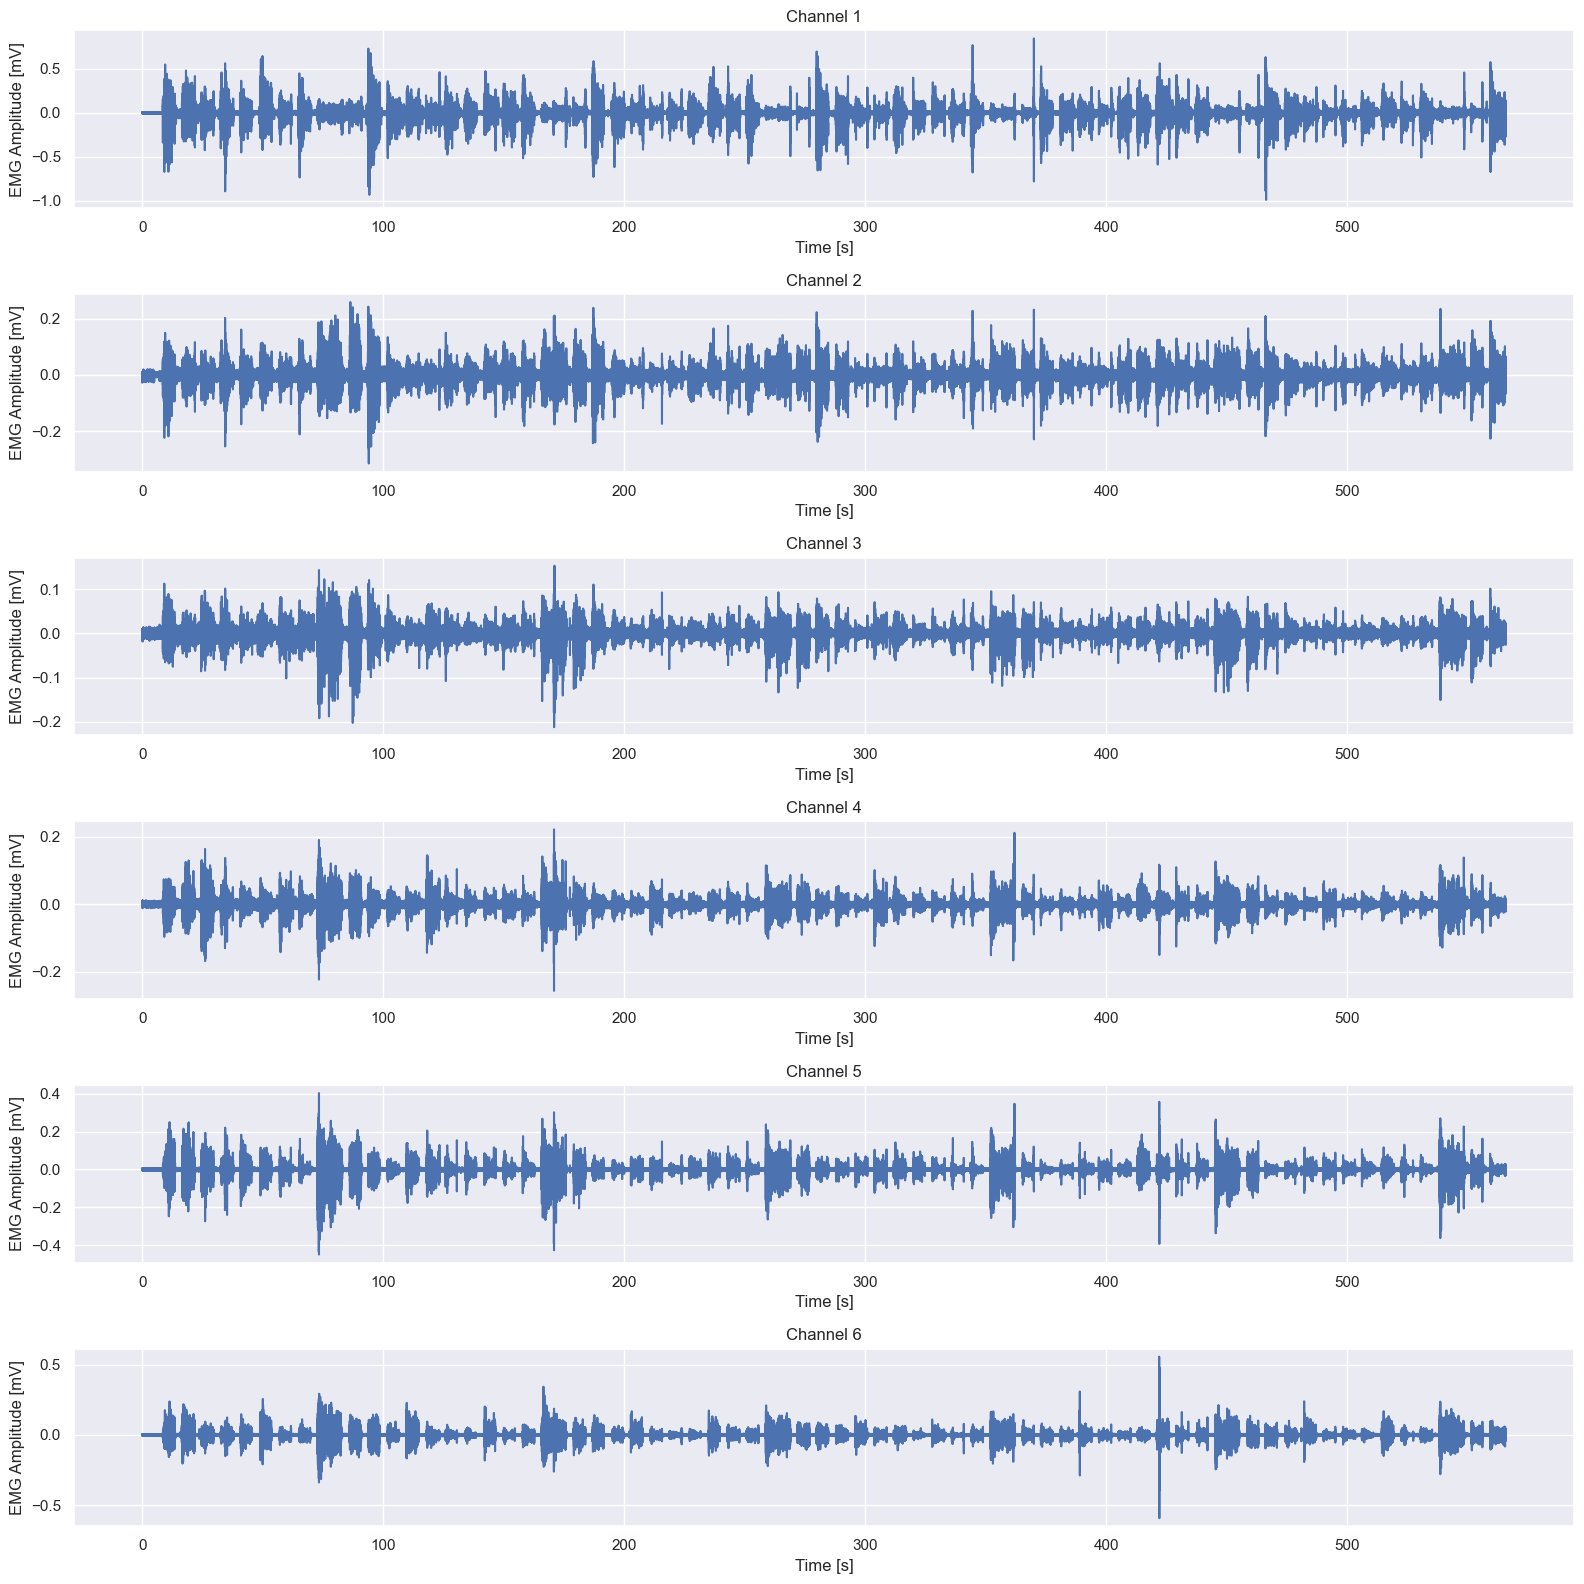

In [9]:
#  Plot EMG data

fig,ax = plt.subplots(n_channels,1,figsize = (16,16))
t = np.arange(0,EMG.shape[0])/sampling_frequency_EMG
for i in range(EMG.shape[1]):
    ax[i].plot(t, EMG[:,i])
    ax[i].set_title(f'Channel {i+1}')
    ax[i].set_ylabel('EMG Amplitude [mV]')
    ax[i].set_xlabel('Time [s]')
plt.tight_layout()

In [10]:
Combinations = Targets_df.groupby(list(Targets_df.columns)).size().reset_index().rename(columns={0:'count'})
Actions_list = ['Open','Pinky grasp','Ring grasp','Ulnar grasp','Middle grasp','Index grasp','Thumb up','Key grasp','Rest','Thumb grasp','Pincer grasp','Tridigital grasp','Power grasp']

Combinations['Actions'] = Actions_list
Combinations


,Right_Hand_channel1,Right_Hand_channel2,Right_Hand_channel3,Right_Hand_channel4,Right_Hand_channel5,Right_Hand_channel6,count,Actions
0,0,0,0,0,0,0,1724,Open
1,0,0,0,0,0,2,1595,Pinky grasp
2,0,0,0,0,2,0,1609,Ring grasp
3,0,0,0,0,2,2,1608,Ulnar grasp
4,0,0,0,2,0,0,1608,Middle grasp
5,0,0,2,0,0,0,1609,Index grasp
6,0,0,2,2,2,2,1758,Thumb up
7,0,2,2,2,2,2,1654,Key grasp
8,1,1,1,1,1,1,13825,Rest
9,2,0,0,0,0,0,1686,Thumb grasp


In the table above you can see the actions that the subject was asked to perform, and the corresponding target states of the fingers. For example in row 0, the subject was asked to open the hand (see in Action column) and therefore all the target channels are 0. In row 1, the action was pinky grasp, therefore we see that only target channel 6 has a value of 2. In row 11, the action was tridigital grasp, corresponding to closing target channels 1-4.



## Interpolate Targets
Align EMG and Targets (interpolate Targets to obtain same sampling frequency).

In [11]:
EMG_df, Targets_df = align(EMG_df,Targets_df)

#convert into numpy array again for easier manipulation
EMG = np.array(EMG_df.values)
Targets = np.array(Targets_df.values)


In the previous segments, we have the information about the target channels, for this exercise, we will focus on classifying the actions itself rather than individual fingers. Hence, we will map the target channels to the corresponding actions. We have done this for you so you can just load the list of actions.

In [12]:
#load action list
Labels = np.load('./action_list.npy')


Lets print the shapes to make sure that they are the same.

In [13]:
print(EMG.shape)
print(Targets.shape)
print(Labels.shape)


(1115731, 6)
(1115731, 6)
(1115731,)


## Cut the dataset

We will cut data into Training, Validation and Testing sets and extract windows. Since there are 6 repetition on each movement we will keep the last repetition for testing and the one before (5th repetition) for the validation set.



In [14]:
def find_nth_repetition(Labels,n):
    """
    This function is defined to find the nth repetition of a given action
    :param action: string containing the action to be found
    :param n: integer containing the number of repetition to be found
    :return: integer containing the index of the nth repetition of the given action
    """
    
    unique_actions = np.unique(Labels)
    action_indices = {action: [] for action in unique_actions}
    last_action = None

    for i, action in enumerate(Labels):
        if action != last_action:
            action_indices[action].append(i)
            last_action = action
    
    nth_repeat_indices = {}
    for action, indices in action_indices.items():
        if len(indices) >= n:
            nth_repeat_indices[action] = indices[n-1]
        else:
            nth_repeat_indices[action] = None 
    
    return nth_repeat_indices


def cut_datasets(EMG, Labels,val_cut, test_cut):

    """
    This function is defined to cut the data in three sets
    :param EMG: pandas DataFrame containing the data
    :param Targets: pandas DataFrame containing the targets
    :param val_cut: information on how/where to cut the dataset to obtain the validation set
    :param test_cut: information on how/where to cut the dataset to obtain the test set
    :return: 6 pandas DataFrames (or numpy arrays) containing EMG and targets of each sets
    """

    EMG_train = EMG[:val_cut]
    EMG_val = EMG[val_cut:test_cut]
    EMG_test = EMG[test_cut:]
    Labels_train = Labels[:val_cut]
    Labels_val = Labels[val_cut:test_cut]
    Labels_test = Labels[test_cut:]


    return EMG_train, EMG_val, EMG_test, Labels_train, Labels_val, Labels_test

In [15]:
val_cut = find_nth_repetition(Labels,5)
test_cut = find_nth_repetition(Labels,6)
print(val_cut)
print(test_cut)

# Sort the nth repetition by values to find first action of that repetition. This is so that we can cut the dataset later
val_cut = {k: v for k, v in sorted(val_cut.items(), key=lambda item: item[1])}
test_cut = {k: v for k, v in sorted(test_cut.items(), key=lambda item: item[1])}
print(val_cut)
print(test_cut)

{'Index grasp': 798831, 'Key grasp': 888505, 'Middle grasp': 782779, 'Open': 920049, 'Pincer grasp': 862701, 'Pinky grasp': 750810, 'Power grasp': 904673, 'Rest': 63400, 'Ring grasp': 766794, 'Thumb grasp': 814344, 'Thumb up': 878740, 'Tridigital grasp': 846743, 'Ulnar grasp': 830762}
{'Index grasp': 984887, 'Key grasp': 1074602, 'Middle grasp': 968902, 'Open': 1106156, 'Pincer grasp': 1048822, 'Pinky grasp': 936934, 'Power grasp': 1090806, 'Rest': 79453, 'Ring grasp': 952890, 'Thumb grasp': 1000439, 'Thumb up': 1064841, 'Tridigital grasp': 1032840, 'Ulnar grasp': 1016890}
{'Rest': 63400, 'Pinky grasp': 750810, 'Ring grasp': 766794, 'Middle grasp': 782779, 'Index grasp': 798831, 'Thumb grasp': 814344, 'Ulnar grasp': 830762, 'Tridigital grasp': 846743, 'Pincer grasp': 862701, 'Thumb up': 878740, 'Key grasp': 888505, 'Power grasp': 904673, 'Open': 920049}
{'Rest': 79453, 'Pinky grasp': 936934, 'Ring grasp': 952890, 'Middle grasp': 968902, 'Index grasp': 984887, 'Thumb grasp': 1000439, 'U

We see that the pinky grasp is the first action of each repetitions (we do not consider resting). We will use this information to cut the dataset in the following part.

In [16]:
#Cut dataset into train, validation and test
EMG_train, EMG_val, EMG_test, Labels_train, Labels_val, Labels_test = cut_datasets(EMG, Labels,val_cut['Pinky grasp'], test_cut['Pinky grasp'])

Lets check the proportion of each dataset.

In [17]:
print(f'Percentage of training set: {EMG_train.shape[0]/EMG.shape[0]*100:.2f}%')
print(f'Percentage of validation set: {EMG_val.shape[0]/EMG.shape[0]*100:.2f}%')
print(f'Percentage of test set: {EMG_test.shape[0]/EMG.shape[0]*100:.2f}%')


Percentage of training set: 67.29%
Percentage of validation set: 16.68%
Percentage of test set: 16.03%


## Sliding Windows

Now, you have to perform an overlapping sliding window with windows of 200ms and a step of 50ms (150ms overlap).

In [18]:
def extract_time_windows(EMG,Labels, fs,win_len,step):
# This function is used to cut the time windows from the raw EMG 
# It return an array containing the EMG of each time window.
# It also returns the labels corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: numpy array containing the data
    :param Labels: numpy array containing the labels
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)
    :return: A numpy arrays containing the windows
    :return: A numpy array containing the labels aligned for each window
    :note: The length of both outputs should be the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = [] 
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window.append(Labels[start_points[i]])
    

    
    
    return EMG_windows, np.array(Labels_window)

In [19]:
#Extract sliding windows
 
train_EMG_window, train_Labels_window = extract_time_windows(EMG_train,Labels_train, sampling_frequency_EMG,window_length,sliding_step)

val_EMG_window, val_Labels_window = extract_time_windows(EMG_val,Labels_val, sampling_frequency_EMG,window_length,sliding_step)

test_EMG_window, test_Labels_window = extract_time_windows(EMG_test,Labels_test, sampling_frequency_EMG,window_length,sliding_step)


## Feature Extraction

Now you will have to extract meaningful information from each EMG channel to be able to decode user intention.

Time features: 

- Mean absolute value (MAV)
- Maximum absolute Value (MaxAV)
- Wavelength (WL): cumulative length of the waveform over time
- Standard Deviation (STD)
- Root mean square (RMS)
- Zero crossing (ZC): number of times the signal crosses zero
- Slope sign changes (SSC): number of times the slope of the EMG changes signs

Frequency features: 

- Mean power 
- Total power
- Mean frequency
- Median frequency 
- Peak frequency


In [20]:
def calc_fft_power(EMG_windows, fs):
    N = EMG_windows.shape[1]  # Number of points in each window
    freqs = np.fft.rfftfreq(N, 1/fs)  # Frequency bins

    # Fast Fourier Transform (FFT)
    fft_vals = np.fft.rfft(EMG_windows, axis=1)
    fft_power = np.abs(fft_vals) ** 2  # Power spectrum
    return freqs[1:], fft_power[:,1:,:]


def extract_features(EMG_windows, fs):
    """
    This function extracts features from raw EMG data. 
    The output matrix containing the features is called X (N_windows*N_features)
    Each feature you decide to extract should be extracted for each EMG channel of each window
    :param windows: List of pandas DataFrames (or numpy arrays) containing the windows
    :return: The matrix X
    """
    # Mean absolute value (MAV)
    mav = np.mean(np.absolute(EMG_windows), axis = 1)

    # Maximum absolute Value (MaxAV)
    maxav = np.max(np.absolute(EMG_windows), axis = 1)

    # Standard Deviation (STD)
    std = np.std(EMG_windows,axis = 1)

    # Root mean square (RMS)
    rms = np.sqrt(np.mean(np.square(EMG_windows), axis=1))

    # Wavelength (WL)
    wl = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1) 

    # Zero crossing (ZC) (hint: you can use np.diff and np.sign to evaluate the zero crossing, then sum the occurance)
    zc = np.sum(np.diff(np.sign(EMG_windows), axis=1) != 0, axis=1) 

    # Slope sign changes (SSC)
    diff = np.diff(EMG_windows, axis=1)
    ssc = np.sum((diff[:, :-1, :] * diff[:, 1: , :]) < 0, axis=1)

    # Get frequency and spectrogram power 
    freqs, fft_power = calc_fft_power(EMG_windows, fs=fs)

    # Mean power 
    mean_power = np.mean(fft_power, axis = 1)

    # Total power
    tot_power = np.sum(fft_power, axis = 1)

    # Mean frequency (sum of the product of spectrogram power and frequency, divided by total sum of spectrogram power)
    freqs_reshaped = freqs.reshape(1, freqs.shape[0], 1) #reshape for multiplication of spectrogram power and frequency 
    mean_frequency = np.sum(fft_power * freqs_reshaped , axis=1) / np.sum(fft_power, axis=1)

    # Median frequency 
    cumulative_power = np.cumsum(fft_power, axis=1)
    total_power = cumulative_power[:, -1, :]
    median_frequency = np.zeros((EMG_windows.shape[0],EMG_windows.shape[2]))

    for i in range(EMG_windows.shape[0]):
        for j in range(EMG_windows.shape[2]):
            median_frequency[i,j] = freqs[np.where(cumulative_power[i, :, j] >= total_power[i,j] / 2)[0][0]]

    # Peak frequency (use np.argmax)
    peak_frequency = freqs[np.argmax(fft_power, axis=1)]


    X = np.column_stack((mav, maxav, std, rms, wl, zc, ssc, mean_power, tot_power, mean_frequency, median_frequency, peak_frequency))

    return X



In [21]:
#Exctract features from training and testing sets
X_train = extract_features(train_EMG_window, sampling_frequency_EMG)
y_train = train_Labels_window

X_val = extract_features(val_EMG_window, sampling_frequency_EMG)
y_val = val_Labels_window

X_test = extract_features(test_EMG_window, sampling_frequency_EMG)
y_test = test_Labels_window

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)



(7505, 72) (7505,)
(1858, 72) (1858,)
(1784, 72) (1784,)


### Feature Standardization

Usually the features are re-scaled either between two bounded values or standardized (e.g $\frac{(x-\mu)}{\sigma}$). We provide the code to perform this step. We extract the mean and standard deviation of each feature from the training set and re-scale the features of all the sets with these values.

In [22]:
Feature_scaler = StandardScaler().fit(X_train)
X_train_z = Feature_scaler.transform(X_train[:,:])
X_val_z = Feature_scaler.transform(X_val[:,:])
X_test_z = Feature_scaler.transform(X_test[:,:])

Why are we doing this step? The primary purpose of standardization is to ensure uniformity in feature scale. For example, if one feature ranges from 0 to 1 and another from 0 to 1000, without standardization, the latter could disproportionately influence the model depending on the algorithm used. Standardization is thus crucial to prevent this imbalance

Explain why it is performed like this and not on all features directly.Standardization is not applied to the validation and test sets because these datasets are intended to simulate real-world data that is yet to be collected. It's impractical to standardize using data we don't yet have. Moreover, including validation and test data in the preprocessing could lead to information leakage. If these datasets were part of the preprocessing, it might artificially inflate the model's performance on them, but this inflated performance might not reflect its ability to handle genuinely new data.

Do you see any limitation of this approach for real time use? A key limitation in real-time scenarios is that if the real-time data significantly deviates from the training dataset, the standardization may become less effective. This mismatch could lead to poorer model performance. Additionally, the extra computation required for standardizing new data in real-time could introduce processing delays, which might slow down the overall system.

### Feature visualization

<Axes: >

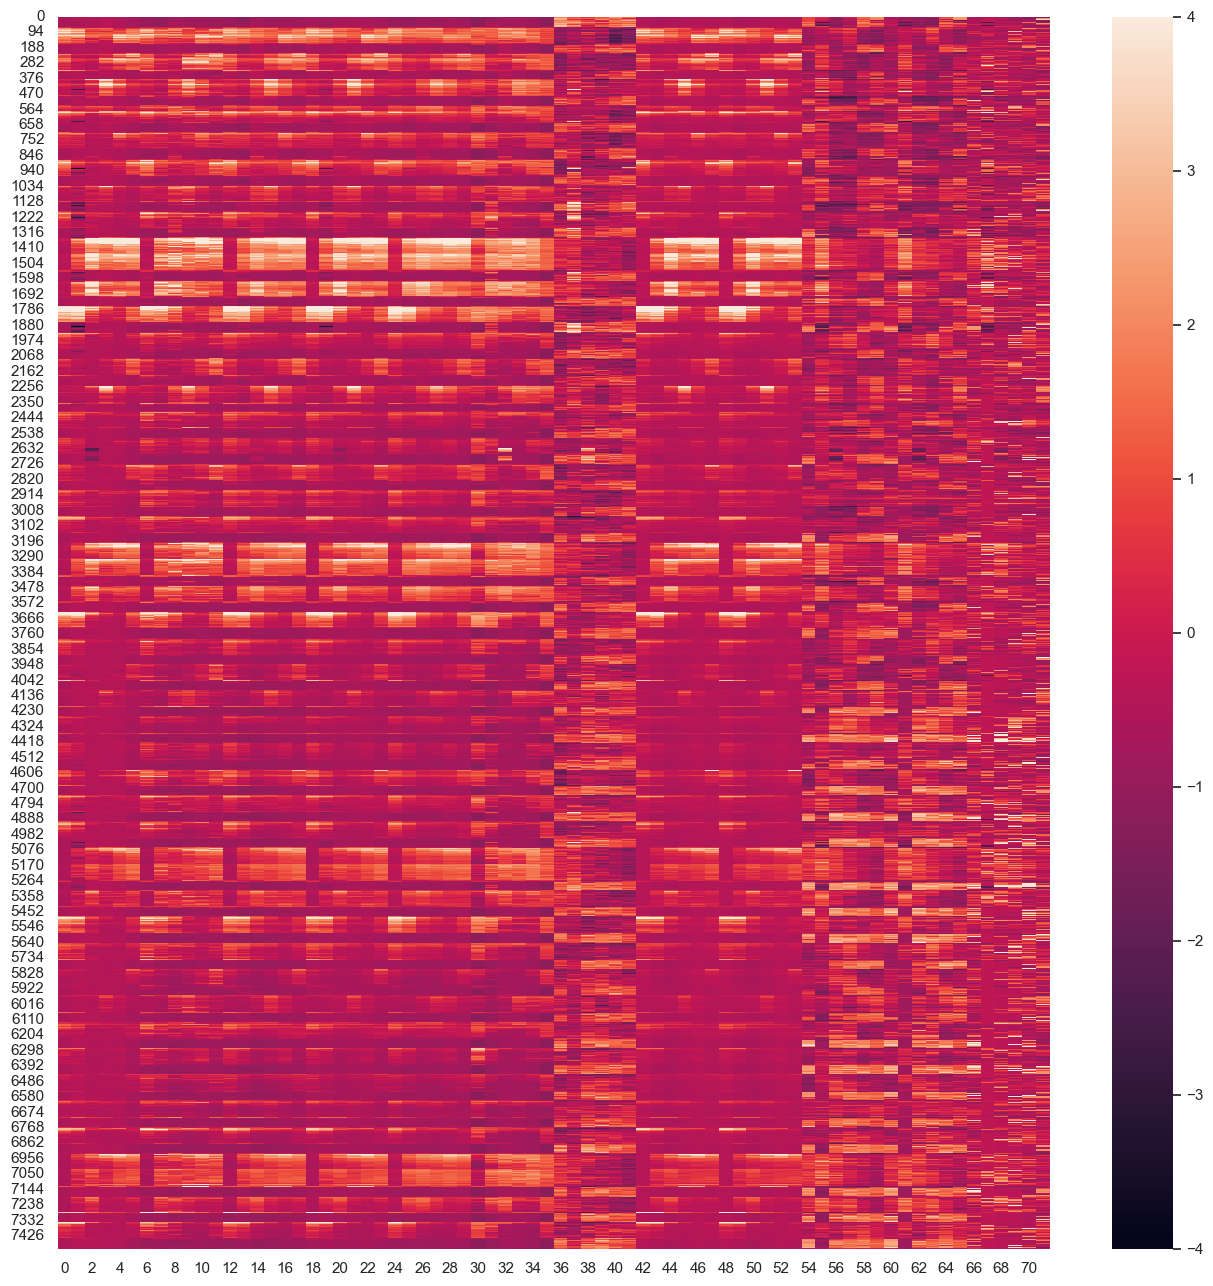

In [23]:
# Lets plot the features
fig,ax = plt.subplots(1,1,figsize = (16,16))
sns.heatmap(X_train_z[:,:],ax=ax, vmin = -4, vmax = 4)


Be aware that the SSC (Slope Sign Changes) feature can often appear quite noisy. A common approach to enhance its robustness is by integrating a threshold within the slope sign change computation. If you're interested in exploring the impact of this modification, you can incorporate the following code snippet into the extract_features(EMG_windows, fs) function. This will allow you to compare the outcomes with and without the use of a threshold.

In [24]:
# threshold=0.01
# ssc = np.zeros((EMG_windows.shape[0],EMG_windows.shape[2]))
# for i in range(EMG_windows.shape[0]):
#     for j in range(EMG_windows.shape[2]):
#         # Calculate SSC with threshold
#         ssc[i, j] = np.sum((np.abs(diff[i, :-1, j]) >= threshold) &
#                        (np.abs(diff[i, 1:, j]) >= threshold) &
#                        (np.sign(diff[i, :-1, j]) != np.sign(diff[i, 1:, j])))

### Plot correlation between features

<Axes: >

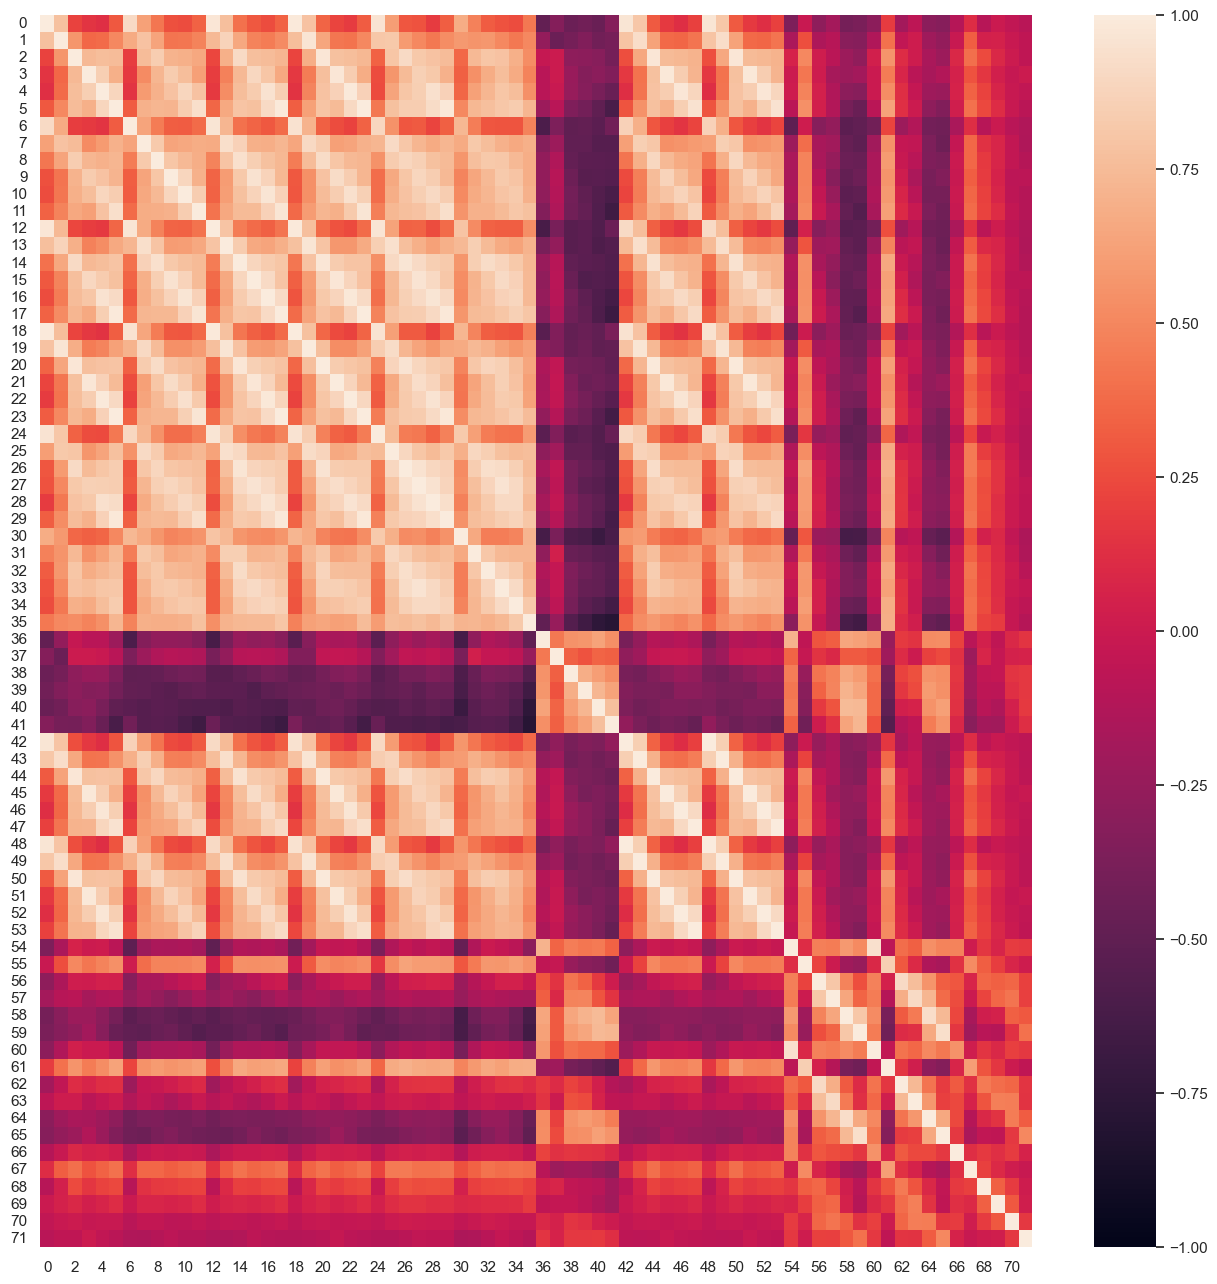

In [25]:
#lets plot the correlation matrix of the features

fig,ax = plt.subplots(1,1,figsize = (16,16))
sns.heatmap(np.corrcoef(X_train_z[:,:].T),ax=ax, vmin = -1, vmax = 1)


## Classification

To train the model, it is good practice to shuffle the training samples (windows) to improve the training of decoders trained with iterative process.

In [26]:
X_train_shuffle, y_train_shuffle = sklearn.utils.shuffle(X_train_z, y_train)

In [27]:
# We can use SVC from sklearn for the classification. Use the fit and predict methods of the classifier.
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_shuffle, y_train_shuffle)
y_pred = clf.predict(X_test_z)



## Model evaluation 
    
Let's evaluate the performance of the model and plot results obtained.

Accuracy of the classification 0.780829596412556


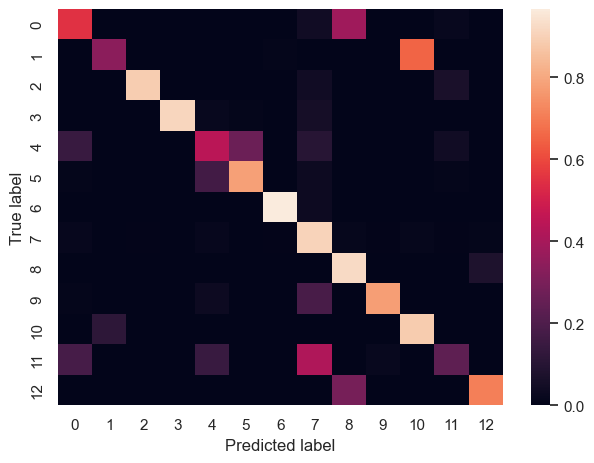

In [28]:
# We can use the metrics available in sklearn to evaluate the performance of the model. 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the classification {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

What can you conclude from the accuracy and confusion matrix?

## Dimension reduction / Feature selection


Following our initial classification using the extracted EMG features, we now move to an advanced stage of our analysis: feature selection and reduction. This process is aimed at refining our model by identifying and retaining the most informative features while discarding those that contribute less to the classification accuracy. After applying these techniques, we will perform another round of classification.

Text(0, 0.5, 'Cumulative explained variance')

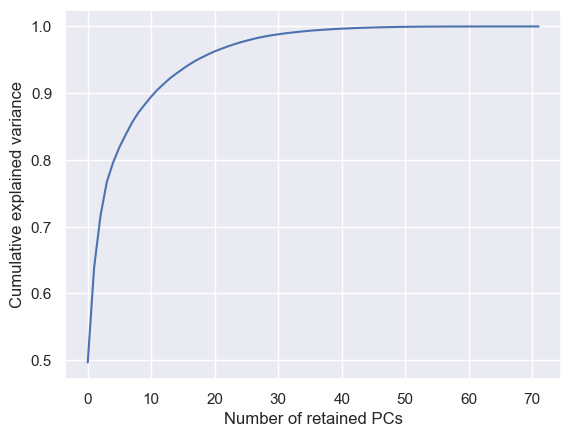

In [29]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_z)
residual_variance = pca.explained_variance_ratio_.cumsum()
fig, ax = plt.subplots()
ax.plot( residual_variance)
ax.set_xlabel("Number of retained PCs")
ax.set_ylabel("Cumulative explained variance")

The plot illustrates how the variance explained in our data changes with the number of features we retain. This could help in selecting the optimal number of features for our analysis.
Typically, we select the number of principal components that explains 90/95% of the variance 

In [30]:
pca = PCA(n_components=0.95)
pca.fit(X_train_z)

X_train_PCA = pca.transform(X_train_z)
X_val_PCA = pca.transform(X_val_z)
X_test_PCA = pca.transform(X_test_z)

In [31]:
X_train_shuffle, y_train_shuffle = sklearn.utils.shuffle(X_train_PCA, y_train)

In [32]:
# We can use SVC from sklearn for the classification. Use the fit and predict methods of the classifier.

clf = SVC()
clf.fit(X_train_shuffle, y_train_shuffle)
y_pred_PCA = clf.predict(X_test_PCA)



0.7628923766816144


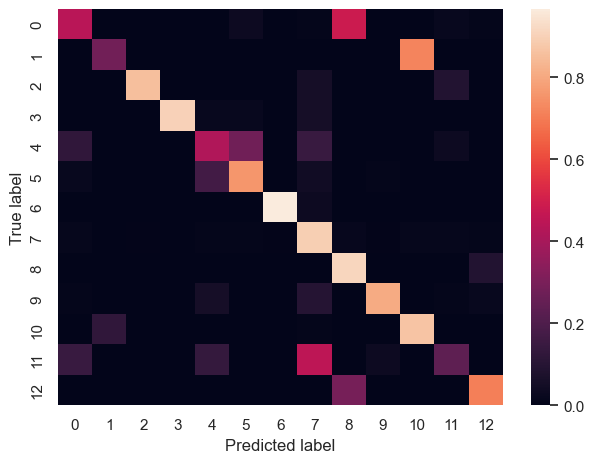

In [33]:
# We can use the compute the accuracy and plot the confusion matrix.

accuracy = accuracy_score(y_test, y_pred_PCA)
print(accuracy)

confmat = confusion_matrix(y_test, y_pred_PCA, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

What can you conclude after performing feature selection? Does the classification improve? What can be other advantages of applying PCA for classification? 

It seems that the performance decreased after running PCA. When PCA leads to lower model performance, it suggests that the dimensionality reduction may have resulted in the loss of important information necessary for accurate classification. This indicates that some of the discarded features or components contained valuable information for predicting the target variable. PCA's effectiveness is highly dependent on the nature of the dataset, and in this case, it seems that the principal components do not capture all the relevant information.

Despite the reduction in classification performance, PCA offers several advantages. It reduces overfitting by eliminating redundant features, especially in large datasets. This simplification can lead to faster training times and lower computational costs. PCA also helps in noise reduction by focusing on the most significant variance components. Additionally, it enables effective visualization of high-dimensional data and ensures feature independence, which is beneficial for certain algorithms.